In [1]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
from scipy.linalg import svd
from tqdm import tqdm

## in this cell I wrote the code for WNNM filter based on the course lectures

In [2]:
def WNNM(img, patchSize, c, K, delta, sigma, nThreshold):
    ## parameters
    windowSize = 3 * patchSize
    pad=windowSize
    paddedImg = np.pad(img, pad_width=pad, mode='constant')
    numberOfIt = 3
    x_hat = img
    total_iterations = K * (paddedImg.shape[0] - 2 * windowSize) * (paddedImg.shape[1] - 2 * windowSize) ## this is for process bar
    with tqdm(total=total_iterations, desc="Processing") as pbar:
        for n in range(K):
            x_hat=np.pad(x_hat,pad_width=pad)
            y_hat = x_hat + delta * (paddedImg - x_hat)
            pixel_contribution_matrix = np.ones_like(paddedImg) ## I use this to know how many times each pixles are updated
            for i in range(windowSize, paddedImg.shape[0] - windowSize):
                for j in range(windowSize, paddedImg.shape[1] - windowSize):
                    window = y_hat[i - windowSize:i + windowSize + 1, j - windowSize: j + windowSize + 1] # Window for searching patches
                    mainPatch = y_hat[i - patchSize:i + patchSize + 1, j - patchSize: j + patchSize + 1] # main Patch
                    distances = [] # List for saving each patch distance with main patch
                    similarPatchMatrix = np.zeros([(2 * patchSize + 1) ** 2, (2 * (windowSize - patchSize) + 1) ** 2]) # patches matrix
                    idx = 0
                    for k in range(patchSize, window.shape[0] - patchSize):
                        for l in range(patchSize, window.shape[1] - patchSize):
                            similarPatch = window[k - patchSize:k + patchSize + 1, l - patchSize:l + patchSize + 1]
                            distance = np.sum((mainPatch - similarPatch) ** 2)
                            distances.append(distance)
                            similarPatchMatrix[:, idx] = similarPatch.flatten()
                            idx += 1
                    min_indices = np.argsort(distances)[:nThreshold] ## finding pathches with minimum distances
                    Yj = similarPatchMatrix[:, min_indices]
                    U, S, V_T = svd(Yj, full_matrices=False)
                    sing_val = np.sqrt(np.maximum(S ** 2 - nThreshold * sigma ** 2, 0))
                    # weights matrix
                    for m in range(numberOfIt):
                        w = c * np.sqrt(nThreshold) / (sing_val + 10 ** (-6))
                        sing_val = np.diag(np.maximum(S - w, 0))
                    # pathc reconstruction
                    Xj_hat = U @ np.diag(np.maximum(S - w, 0)) @ V_T
                    x_patch = np.clip(Xj_hat[:, 0].reshape((2 * patchSize + 1, 2 * patchSize + 1)), 0, 1)
                    x_hat[i - patchSize:i + patchSize + 1, j - patchSize: j + patchSize + 1] += x_patch
                    mainPatchRegion = (i - patchSize, i + patchSize + 1, j - patchSize, j + patchSize + 1)
                    pixel_contribution_matrix[mainPatchRegion[0]:mainPatchRegion[1], mainPatchRegion[2]:mainPatchRegion[3]] += 1
                    pbar.update(1)
            # removing pads
            x_hat = x_hat[pad:-pad, pad:-pad]
            pixel_contribution_matrix = pixel_contribution_matrix[pad:-pad, pad:-pad]
            x_hat=x_hat / pixel_contribution_matrix

    return x_hat



In [17]:
img = cv.imread('/content/Low Matrix Approximation question.jpg', 0) / 255
patchSize = 3
delta = 0.1
c = 2.8
K = 3
sigma = 1
nThreshold = 35
noisy_img = img + np.random.normal(loc=0, scale=1, size=img.shape)
noisy_img = np.clip(noisy_img, 0, 1)
denoised_img = WNNM(noisy_img, patchSize, c, K, delta, sigma, nThreshold)

Processing: 100%|██████████| 2308326/2308326 [1:45:24<00:00, 364.97it/s]


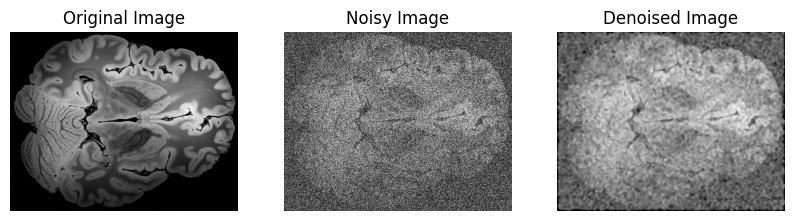

In [18]:
plt.figure(figsize=(10, 6))

plt.subplot(1, 3, 1)
plt.imshow(img, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(noisy_img, cmap='gray')
plt.title('Noisy Image')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(denoised_img, cmap='gray')
plt.title('Denoised Image')
plt.axis('off')

plt.show()

In [19]:
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
ssim_denoised = ssim(img, denoised_img)
psnr_denoised = psnr(img, denoised_img)
ssim_Noisy=ssim(img,noisy_img)
psnr_Noisy=psnr(img, noisy_img)
print(f"SSIM Denoised: {ssim_denoised:.4f}")
print(f"PSNR Denoised: {psnr_denoised:.2f} dB")
print(f"SSIM Noisy: {ssim_Noisy:.4f}")
print(f"PSNR Noisy: {psnr_Noisy:.2f} dB")

SSIM Denoised: 0.4178
PSNR Denoised: 14.58 dB
SSIM Noisy: 0.0243
PSNR Noisy: 6.69 dB


In [20]:
cv.imwrite('denoised_image.png', denoised_img * 255)

True